# Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Matplolib default parameters
from matplotlib import rcParams
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

# import warning
import warnings
warnings.filterwarnings('ignore')

# Set option max columns display
pd.set_option('max_columns', 150)
pd.set_option('max_colwidth', 150)
pd.set_option('max_rows', 100)

# Dataset Overview

In [4]:
data = pd.read_csv('Year_2010-2011.csv', encoding='cp1252')
data.sample(5, random_state=364)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
33036,539217,22697,GREEN REGENCY TEACUP AND SAUCER,6,12/16/2010 12:46,2.95,15394.0,United Kingdom
9716,537212,22197,SMALL POPCORN HOLDER,24,12/5/2010 15:21,0.85,12720.0,Germany
347163,567290,22667,RECIPE BOX RETROSPOT,24,9/19/2011 11:54,2.55,14646.0,Netherlands
264234,560090,21725,SWEETIES STICKERS,1,7/14/2011 16:46,1.63,NaN,United Kingdom
141515,548516,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,3/31/2011 16:28,2.46,NaN,United Kingdom


In [5]:
print(f'Dataset consist of {data.shape[0]} Rows and {data.shape[1]} Columns')

Dataset consist of 541910 Rows and 8 Columns


In [6]:
# Create Data Info
list_item = []
for col in data.columns:
    list_item.append([col, data[col].dtype, data[col].isna().sum(), 100*data[col].isna().sum()/len(data[col]), data[col].nunique(), data[col].unique()[:4]])
desc_df = pd.DataFrame(data=list_item, columns='feature data_type null_num null_pct unique_num unique_sample'.split())
desc_df

,feature,data_type,null_num,null_pct,unique_num,unique_sample
0,Invoice,object,0,0.000000,25900,"[536365, 536366, 536368, 536367]"
1,StockCode,object,0,0.000000,4070,"[85123A, 71053, 84406B, 84029G]"
2,Description,object,1454,0.268310,4223,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE METAL LANTERN, CREAM CUPID HEARTS COAT HANGER, KNITTED UNION FLAG HOT WATER BOTTLE]"
3,Quantity,int64,0,0.000000,722,"[6, 8, 2, 3]"
4,InvoiceDate,object,0,0.000000,23260,"[12/1/2010 8:26, 12/1/2010 8:28, 12/1/2010 8:34, 12/1/2010 8:35]"
5,Price,float64,0,0.000000,1630,"[2.55, 3.39, 2.75, 7.65]"
6,Customer ID,float64,135080,24.926648,4372,"[17850.0, 13047.0, 12583.0, 13748.0]"
7,Country,object,0,0.000000,38,"[United Kingdom, France, Australia, Netherlands]"


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      541910 non-null  object 
 1   StockCode    541910 non-null  object 
 2   Description  540456 non-null  object 
 3   Quantity     541910 non-null  int64  
 4   InvoiceDate  541910 non-null  object 
 5   Price        541910 non-null  float64
 6   Customer ID  406830 non-null  float64
 7   Country      541910 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Feature Engineering

In [8]:
#change data type
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# create new features
data['Dayofmonth'] = data['InvoiceDate'].dt.day
data['Day_name'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month
data['Year'] = data['InvoiceDate'].dt.year
data['Hour'] = data['InvoiceDate'].dt.hour

In [9]:
# create sales feature
data['Sales'] = data['Price']*data['Quantity']

# RFM Segmentation

## Get Data

In [10]:
rfm_cols = ['Customer ID', 'InvoiceDate', 'Sales']
rfm_data = data[rfm_cols]
rfm_data.head()

,Customer ID,InvoiceDate,Sales
0,17850.0,2010-12-01 08:26:00,15.30
1,17850.0,2010-12-01 08:26:00,20.34
2,17850.0,2010-12-01 08:26:00,22.00
3,17850.0,2010-12-01 08:26:00,20.34
4,17850.0,2010-12-01 08:26:00,20.34


In [11]:
from lifetimes.plotting import *
from lifetimes.utils import *

#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

rfm_data = summary_data_from_transaction_data(rfm_data, 'Customer ID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
rfm_data.reset_index().head()

,Customer ID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


1. frequency <br>
frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.


2. T <br>
T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.


3. Recency <br>
recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)


4. monetary_value <br>
monetary_value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

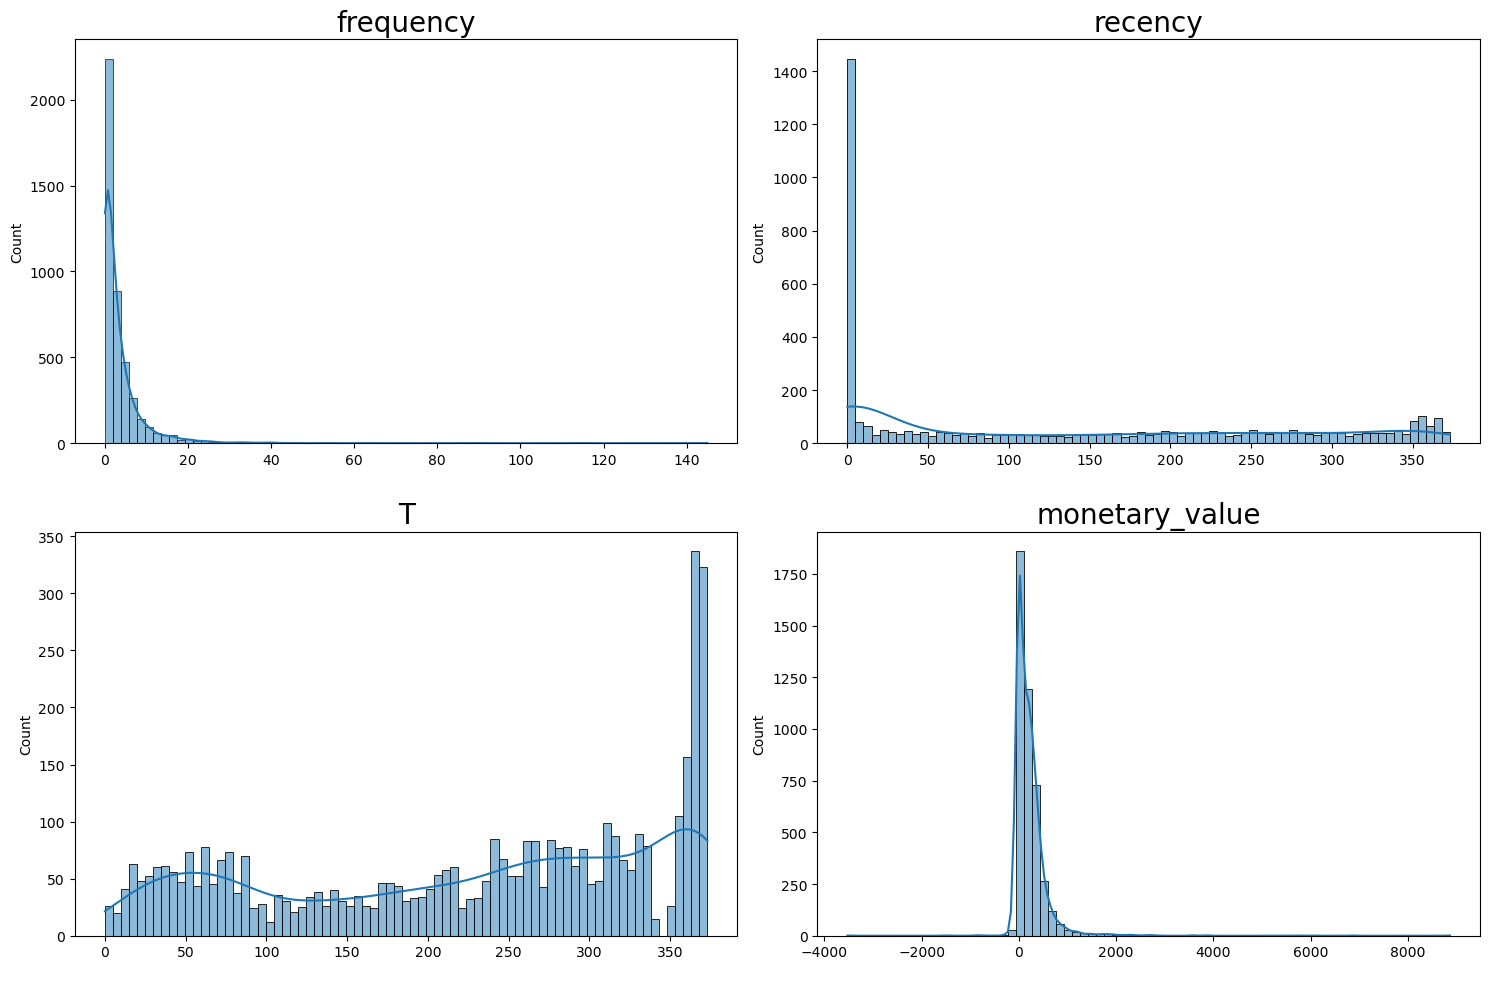

In [12]:
plt.figure(figsize=(15,10))
for col in range(0, len(rfm_data.columns)):
    plt.subplot(2,2,col+1)
    sns.histplot(x=rfm_data[rfm_data.columns[col]], bins=75, kde=True, palette='Blues_d')
    plt.xlabel(' ')
    plt.title(rfm_data.columns[col], fontsize=20)
    plt.tight_layout()

In [13]:
rfm_data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [14]:
# remove T
rfm_df = rfm_data[['frequency', 'recency', 'monetary_value']]
rfm_df.head()

,frequency,recency,monetary_value
Customer ID,,,
12346.0,0.0,0.0,0.000000
12347.0,6.0,365.0,599.701667
12348.0,3.0,283.0,301.480000
12349.0,0.0,0.0,0.000000
12350.0,0.0,0.0,0.000000


## Standardization

In [15]:
from sklearn.preprocessing import StandardScaler

sc_data = StandardScaler()
data_std = sc_data.fit_transform(rfm_df)

In [16]:
data_std = pd.DataFrame(data_std, columns=rfm_df.columns)
data_std.head()

,frequency,recency,monetary_value
0,-0.511501,-1.005548,-0.572088
1,0.387567,1.739117,1.036694
2,-0.061967,1.122508,0.236674
3,-0.511501,-1.005548,-0.572088
4,-0.511501,-1.005548,-0.572088


## Elbow Method

<AxesSubplot:>

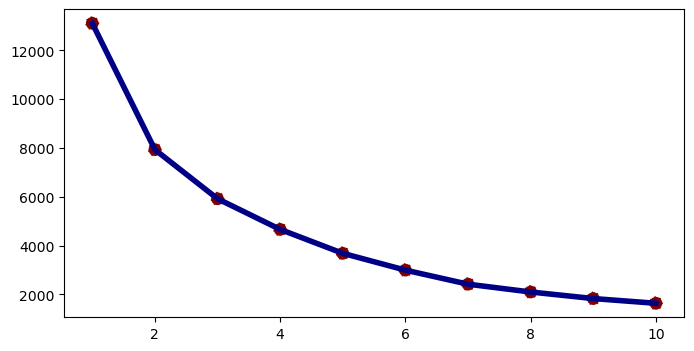

In [17]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=123)
    kmeans.fit(data_std)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 4))

# plt.plot(inertia)
sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 11), y=inertia, s=100, color='#800000',  linestyle='--')

In [18]:
# K-Means Clustering
# Even elbow method shows 2 cluster is most effective segments, we will try using 3 segments based on business needs
kmeans = KMeans(n_clusters=3, random_state=0)

# fit model 
kc = kmeans.fit(data_std.values)
cluster_labels = kc.labels_

# add cluster
data_cluster = data_std.assign(K_Cluster = cluster_labels)
data_cluster.head()

,frequency,recency,monetary_value,K_Cluster
0,-0.511501,-1.005548,-0.572088,0
1,0.387567,1.739117,1.036694,2
2,-0.061967,1.122508,0.236674,2
3,-0.511501,-1.005548,-0.572088,0
4,-0.511501,-1.005548,-0.572088,0


In [19]:
# add label to 'data' dataframe
data_label = rfm_df.assign(K_Cluster = cluster_labels)
data_label.head()

,frequency,recency,monetary_value,K_Cluster
Customer ID,,,,
12346.0,0.0,0.0,0.000000,0
12347.0,6.0,365.0,599.701667,2
12348.0,3.0,283.0,301.480000,2
12349.0,0.0,0.0,0.000000,0
12350.0,0.0,0.0,0.000000,0


## Insights

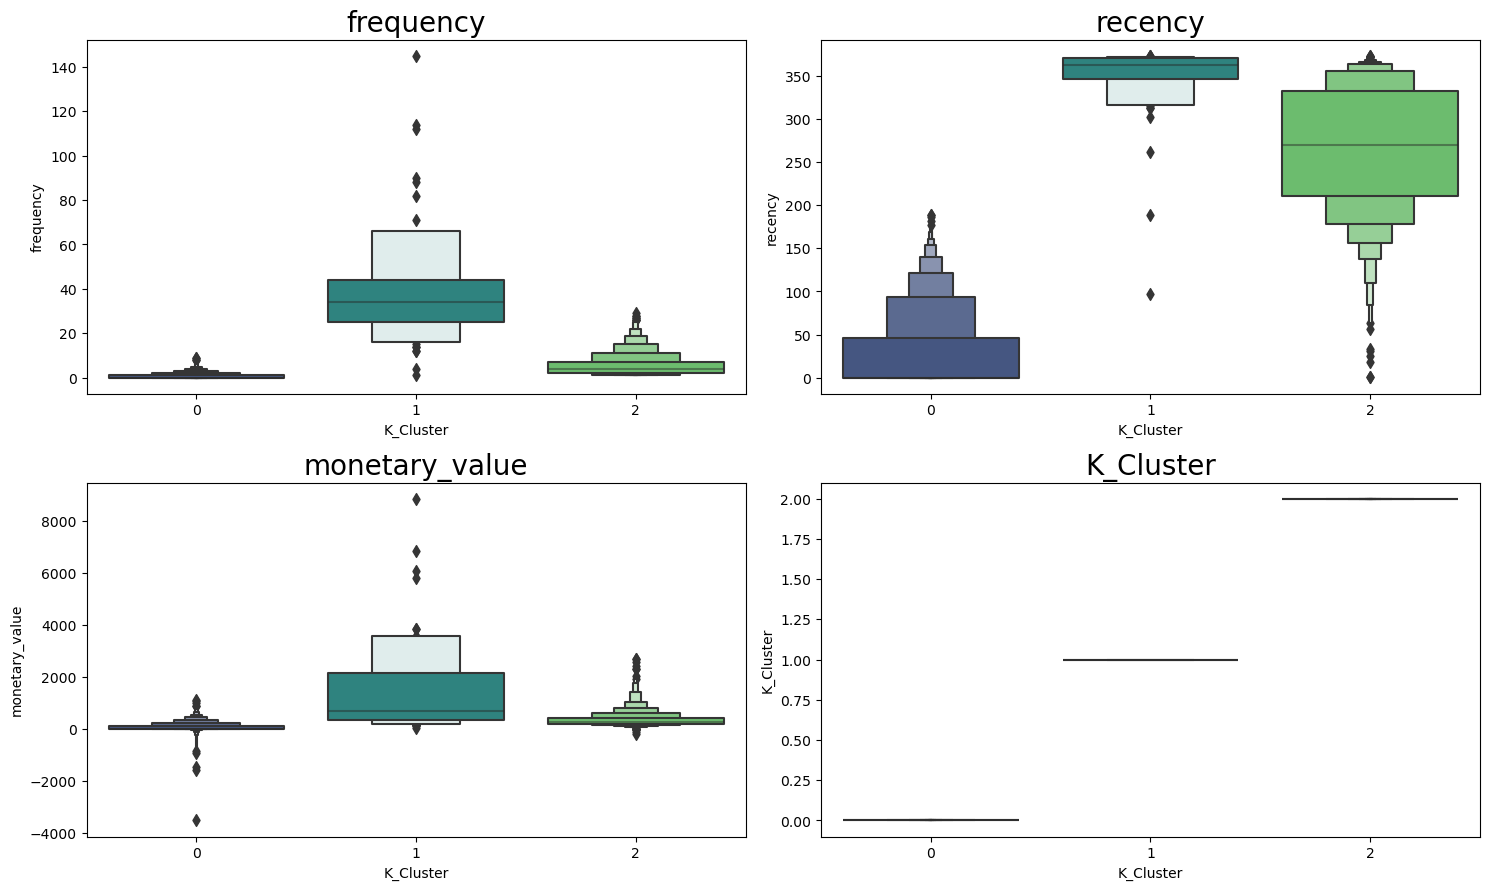

In [20]:
plt.figure(figsize=(15,13))
for col in range(0, len(data_label.columns)):
    plt.subplot(3,2,col+1)
    sns.boxenplot(x=data_label['K_Cluster'], y=data_label[data_label.columns[col]], palette='viridis')
    plt.title(data_label.columns[col], fontsize=20)
    plt.tight_layout()

## Snake Plot

In [21]:
rfm_normalized_melt = pd.melt(data_cluster, id_vars=['K_Cluster'], 
                              value_vars=['recency', 'frequency', 'monetary_value'],
                              var_name='Metric', value_name='Value')

In [22]:
rfm_normalized_melt.head()

,K_Cluster,Metric,Value
0,0,recency,-1.005548
1,2,recency,1.739117
2,2,recency,1.122508
3,0,recency,-1.005548
4,0,recency,-1.005548


<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Metric', ylabel='Value'>

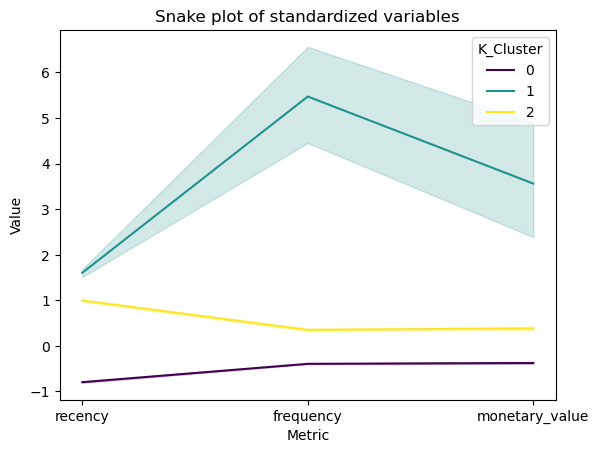

In [23]:
plt.title("Snake plot of standardized variables");
sns.lineplot(x='Metric', y='Value', hue='K_Cluster', data=rfm_normalized_melt, palette='viridis')

- Cluster 1 : `Best Customers` --> Bought most frequently, high spender, high recency
- Cluster 2 : `Average Customers` -->  So so
- Cluster 0 : `Low Spender` --> Spend less, small recency, low frequent

# RFM Analysis

In [25]:
rfm_data.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [26]:
rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,4372.0,3.413541,6.674343,0.00,0.0,1.000,4.0000,145.000000
recency,4372.0,133.723010,133.000474,0.00,0.0,98.000,256.0000,373.000000
T,4372.0,225.304209,118.384168,0.00,115.0,253.000,331.0000,373.000000
monetary_value,4372.0,213.255688,372.810120,-3528.34,0.0,148.955,304.9425,8866.081538


In [41]:
# change to absolute (letsay our input is false, so we need to absulte all the values)
rfm_datas = rfm_data.abs()
rfm_datas = rfm_datas.drop('T', axis=1)
rfm_datas.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,4372.0,3.413541,6.674343,0.0,0.0,1.0000,4.000000,145.000000
recency,4372.0,133.723010,133.000474,0.0,0.0,98.0000,256.000000,373.000000
monetary_value,4372.0,220.663076,368.473127,0.0,0.0,151.1775,305.634121,8866.081538


## Set Bins

In [42]:
# set the bins [<min, x, x, max]
r_bins = [-1, 0, 256, 373]
f_bins = [-1, 0, 4, 145]
m_bins = [-1, 0, 305.634121, 8866.081538]
rfm_datas['r_score'] = pd.cut(rfm_datas['recency'], r_bins, labels = [3, 2, 1])
rfm_datas['f_score'] = pd.cut(rfm_datas['frequency'], f_bins, labels = [1, 2, 3])
rfm_datas['m_score'] = pd.cut(rfm_datas['monetary_value'], m_bins, labels = [1, 2, 3])

In [46]:
rfm_datas.head()

,frequency,recency,monetary_value,r_score,f_score,m_score
Customer ID,,,,,,
12346.0,0.0,0.0,0.000000,3,1,1
12347.0,6.0,365.0,599.701667,1,3,3
12348.0,3.0,283.0,301.480000,1,2,2
12349.0,0.0,0.0,0.000000,3,1,1
12350.0,0.0,0.0,0.000000,3,1,1


## Calculate Score

In [55]:
rfm_datas.isna().sum()

frequency         0
recency           0
monetary_value    0
r_score           0
f_score           0
m_score           1
dtype: int64

In [56]:
rfm_datas = rfm_datas.dropna()
rfm_datas.isna().sum()

frequency         0
recency           0
monetary_value    0
r_score           0
f_score           0
m_score           0
dtype: int64

In [58]:
rfm_datas['r_score'] = rfm_datas['r_score'].astype(int)
rfm_datas['f_score'] = rfm_datas['f_score'].astype(int)
rfm_datas['m_score'] = rfm_datas['m_score'].astype(int)

In [60]:
rfm_datas['rfm_score'] = rfm_datas[['r_score', 'f_score', 'm_score']].sum(axis=1)
rfm_datas.head()

,frequency,recency,monetary_value,r_score,f_score,m_score,rfm_score
Customer ID,,,,,,,
12346.0,0.0,0.0,0.000000,3,1,1,5
12347.0,6.0,365.0,599.701667,1,3,3,7
12348.0,3.0,283.0,301.480000,1,2,2,5
12349.0,0.0,0.0,0.000000,3,1,1,5
12350.0,0.0,0.0,0.000000,3,1,1,5


In [63]:
rfm_datas['rfm_score'].unique()

array([5, 7, 6, 8])

In [64]:
rfm_datas['rfm_group'] = np.where(rfm_datas['rfm_score']==8,'Champions',
                         np.where(rfm_datas['rfm_score']==7,'Potential Loyalists',
                         np.where(rfm_datas['rfm_score']==6,'New Customers','At Risk Customers')))

rfm_datas['rfm_group'].value_counts()

At Risk Customers      1634
New Customers          1624
Potential Loyalists    1008
Champions               105
Name: rfm_group, dtype: int64

## Plot

In [98]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_datas_agg = rfm_datas.groupby('rfm_group').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
rfm_datas_agg.head()

recency frequency monetary_value      
                       mean      mean           mean count
rfm_group                                                 
At Risk Customers      46.9       0.4           28.0  1634
Champions             185.8       7.0          531.7   105
New Customers         172.7       4.1          193.4  1624
Potential Loyalists   205.9       6.8          536.0  1008

In [96]:
rfm_datas_agg = rfm_datas_agg.reset_index()
rfm_datas_agg['pctg'] = rfm_datas_agg['Count']/rfm_datas_agg['Count'].sum()*100
rfm_datas_agg

,rfm_group,RecencyMean,FrequencyMean,MonetaryMean,Count,pctg
0,At Risk Customers,46.9,0.4,28.0,1634,37.382750
1,Champions,185.8,7.0,531.7,105,2.402196
2,New Customers,172.7,4.1,193.4,1624,37.153969
3,Potential Loyalists,205.9,6.8,536.0,1008,23.061084


In [69]:
import squarify

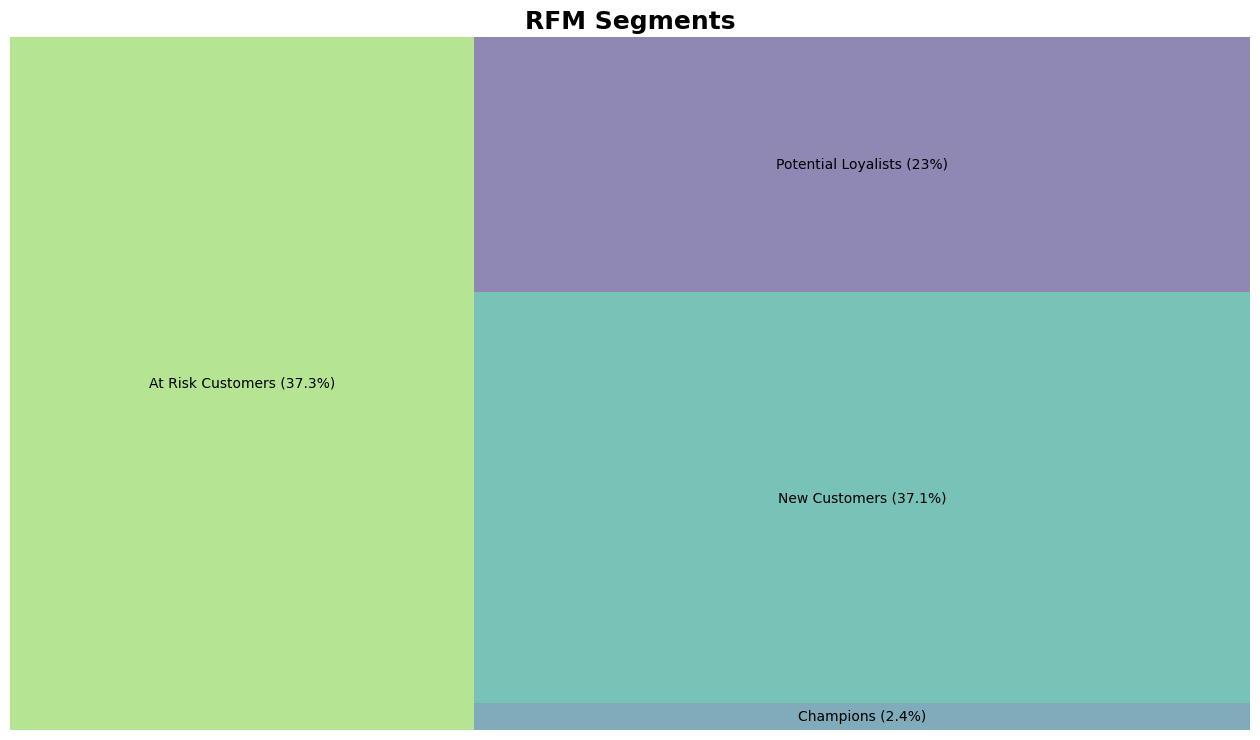

In [99]:
rfm_datas_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_datas_agg['Count'], 
              label=['At Risk Customers (37.3%)',
                     'Champions (2.4%)',
                     'New Customers (37.1%)',
                     'Potential Loyalists (23%)'], alpha=.6 )

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

- Champions are your best customers, who bought most recently, most often, and are heavy spenders. Reward these customers. They can become early adopters for new products and will help promote your brand.
- Potential Loyalists are your recent customers with average frequency and who spent a good amount. Offer membership or loyalty programs or recommend related products to upsell them and help them become your Loyalists or Champions.
- New Customers are your customers who have a high overall RFM score but are not frequent shoppers. Start building relationships with these customers by providing onboarding support and special offers to increase their visits.
- At Risk Customers are your customers who purchased often and spent big amounts, but haven’t purchased recently. Send them personalized reactivation campaigns to reconnect, and offer renewals and helpful products to encourage another purchase.